<!-- # Helmholtz equation solved using stabilised finite element methods

`dolfinx` implementation of method described in the paper

> E. Burman, M. Nechita and L. Oksanen, Unique continuation for the Helmholtz equation using stabilized finite element methods, *J. Math. Pures Appl.*, 2019. https://doi.org/10.1016/j.matpur.2018.10.003 -->

Our aim is to solve the Stokes' Problem 

$$
  -\Delta u(x) + \nabla p = f(x)  \text{ for }x \in \Omega, \\
  \nabla \cdot u(x) = 0 \text{ for } x \in \Omega,\\
  u=0  \text{ on }\  \partial \Omega
$$ 

on a spatial domain $\Omega$, $u \in H^2(\Omega)$, $u=(20xy^3, 5x^4-5y^4)$, $p=60x^2y-20y^3-5$ are the given exact solutions and $f$, the source term.


we can produce the stabilized FEM for the stokes problem for https://fenicsproject.org/olddocs/dolfin/1.3.0/python/demo/documented/stokes-stabilized/python/documentation.html

We can also produce the 6.2 example of the article.
https://reader.elsevier.com/reader/sd/pii/S0377042705007053?token=EBD27758065511285CF9906AF40C4A6038D4898918255DC94D518A2B431030B9648DE3A558FDFDB868B63C53ED671EFC&originRegion=eu-west-1&originCreation=20220328075309

In [1]:
import ufl
import dolfinx
from dolfinx.fem import FunctionSpace, assemble_scalar, dirichletbc, form, Constant, locate_dofs_topological, Function, Expression
from dolfinx.fem.petsc import LinearProblem, assemble_matrix
from dolfinx_helpers import (
    get_matplotlib_triangulation_from_mesh,
    define_dirchlet_boundary_conditions,
    project_expression_on_function_space,
    plot_functions_as_heatmaps
)
from dolfinx.mesh import compute_boundary_facets, create_unit_square, DiagonalType, locate_entities, refine, compute_incident_entities, GhostMode
from dolfinx.cpp.mesh import h
from mpi4py import MPI
import numpy as np
import matplotlib.pyplot as plt
import dolfinx.io
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
from slepc4py import SLEPc
from ufl import (CellDiameter, SpatialCoordinate, div, dx, ds, grad, inner)
from meshes import create_initial_mesh_convex, get_mesh_convex_EB,get_mesh_convex_new_EB, get_mesh_hierarchy,get_mesh_hierarchy_nonconvex,get_mesh_omega_enclose_B,get_mesh_flow_downstream,get_mesh_flow_upstream
from dolfinx.io import XDMFFile
import matplotlib.pyplot as plt 
from math import log
import os
np.random.seed(0)

In [2]:
def get_h_max(mesh):
    mesh.topology.create_connectivity(2, 0)
    triangles = mesh.topology.connectivity(2, 0).array.reshape((-1, 3))
    return h(mesh, 2, triangles).max()

def problem_name(well_posed, domain_case, order,theta):
    if theta == None:
        return "Navier-Stokes-{0}-{1}-order{2}".format(
        "well-posed" if well_posed else "ill-posed",
        domain_case,
        order)
    else:
        return "Navier-Stokes-{0}-{1}-order{2}-theta{3}".format(
        "well-posed" if well_posed else "ill-posed",
        domain_case,
        order,theta)

def condest(bilinear_form,bcs,msh,target_shift=1e-13):
    print("bcs =", bcs)
    A = assemble_matrix(form(bilinear_form), bcs)
    A.assemble()
   
    Ainv = PETSc.KSP().create(msh.comm)
    Ainv.setOperators(A)
    Ainv.setType(PETSc.KSP.Type.PREONLY)
    Ainv.getPC().setType(PETSc.PC.Type.LU)

    eigensolver = SLEPc.EPS().create(MPI.COMM_WORLD)
    eigensolver.setOperators(A)
    eigensolver.setDimensions(nev=1)

    eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.LARGEST_MAGNITUDE)
    eigensolver.setProblemType(SLEPc.EPS.ProblemType.NHEP)
    eigensolver.solve()
    eigen_max = eigensolver.getEigenvalue(0)
    
    shift = eigensolver.getST()
    shift.setType(SLEPc.ST.Type.SINVERT)

    eigensolver.setST(shift)
    eigensolver.setOperators(A)
    #eigensolver.setTarget(1e-10)
    eigensolver.setTarget(target_shift)
    eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_REAL)
    eigensolver.setType('krylovschur')
    eigensolver.setFromOptions()
    eigensolver.setUp()
    eigensolver.solve()

    evs = eigensolver.getConverged()
    eigen_min = eigensolver.getEigenvalue(0)
    cond_est = abs(eigen_max)/abs(eigen_min)
    print("cond = " , cond_est)
    return cond_est

## Define mesh
We use $\Omega = [0, 1] \times [0, 1]$ therefore create a unit square mesh with alternating diagonal triangulation.

In [3]:
subdomain_cases = ["convex-Stokes","convex-Stokes_new","convex-Helmholtz","nonconvex-Helmholtz","omega_enclose_B","flow_downstream","flow_upstream"]
#problem_types = ["well-posed","ill-posed"]

In [4]:
# setting parameters ###############
order= 1
#perturb_order = 0 
theta = None
if theta == None:
    perturb_order = None
else:
    perturb_order = order - theta
#perturb_order = 1
well_posed =  False
estimate_cond = False
give_pressure = True
convective_scaling = False

domain_case = subdomain_cases[5]
gamma = { "Jump": 1e-01, 
         "GLS": 1e-01,
        "Tikhonov": 1e-01,
         "Div": 1e-01,
         "Data": 1e+3,
         "Dual-u": 1e-1,
         "Dual-p": 1e-1
       }
# gamma = { "Jump": 1e5, 
#           "GLS": 1e5,
#          "Tikhonov": 1e-10,
#           "Div": 1e-10,
#           "Data": 1e-10,
#           "Dual-u": 1e-10,
#           "Dual-p": 1e-10
#         }
####################################

diffusion_coff=  1

height = 1 
P_const = 1
mu = 1
#U_flow = get_background_flow(mesh)
U_infty = P_const*height**2/(2*mu)

In [5]:
def get_background_flow(mesh): 
    x = ufl.SpatialCoordinate(mesh)
    U_flow =  ufl.as_vector([P_const/(2*mu)*(height**2-x[1]**2), 0.0 ])
    return U_flow

In [6]:
def get_mesh(domain_case):
    if domain_case == "convex-Helmholtz":
        mesh = create_initial_mesh_convex(init_h_scale=1.0)
    elif domain_case == "convex-Stokes":
        mesh = get_mesh_convex_EB(init_h_scale=1.0)
    elif domain_case == "convex-Stokes_new":
        mesh = get_mesh_convex_new_EB(init_h_scale=1.0)
    elif domain_case == "nonconvex-Helmholtz":
        mesh = get_mesh_hierarchy_nonconvex(n_ref=0,init_h_scale=1.0)[0]
    elif domain_case == "omega_enclose_B":
        mesh = get_mesh_omega_enclose_B(init_h_scale=1.0)
    elif domain_case == "flow_downstream":
        mesh = get_mesh_flow_downstream(init_h_scale=1.0)
    elif domain_case == "flow_upstream":
        mesh = get_mesh_flow_upstream(init_h_scale=1.0)
    else:
        raise ValueError(f"Unrecognised domain_case: {domain_case}")
    return mesh

In [7]:
#def create_mesh(num_cells_per_dimension):
#    mesh = create_unit_square(
#        comm=MPI.COMM_WORLD, 
#        nx=num_cells_per_dimension, 
#        ny=num_cells_per_dimension, 
#        diagonal=DiagonalType.right_left
#    )
#    return mesh

## Stokes problem variational forms

$$ G((u,p), (v,q)) = \int_{\Omega} (\nabla u \cdot \nabla v -  p \nabla \cdot v +q \nabla \cdot u) \,\mathrm{d}x $$

$$ b(v) = \int_{\Omega} f v \,\mathrm{d}x $$


In [8]:
def Stokes_problem_bilinear_form(trial_function_u, trial_function_p, test_function_u, test_function_p, diffusion_coff,U_flow):
    mesh = trial_function_u.ufl_domain().ufl_cargo()
    return (
        diffusion_coff*ufl.inner(ufl.grad(trial_function_u), ufl.grad(test_function_u)) 
        + ufl.dot( ufl.grad(trial_function_u) * U_flow, test_function_u )
        + ufl.dot( ufl.grad(U_flow) * trial_function_u, test_function_u )
        #+ ufl.inner(ufl.dot(U_flow,ufl.grad(trial_function_u)) , ) 
        - trial_function_p*ufl.div(test_function_u) + test_function_p * ufl.div(trial_function_u)
    ) * ufl.dx

def Stokes_problem_linear_form(test_function_u, source_expression):
    return source_expression * test_function_u * ufl.dx 

In [9]:
# def Stokes_problem_bilinear_form(trial_function_u, trial_function_p, test_function_u, test_function_p, diffusion_coff,U_flow):
#     mesh = trial_function_u.ufl_domain().ufl_cargo()
#     return (
#         diffusion_coff*ufl.inner(ufl.grad(trial_function_u), ufl.grad(test_function_u)) 
#         + ufl.dot( ufl.grad(trial_function_u) * U_flow, test_function_u )
#         #+ ufl.inner(ufl.dot(U_flow,ufl.grad(trial_function_u)) , ) 
#         - trial_function_p*ufl.div(test_function_u) + test_function_p * ufl.div(trial_function_u)
#     ) * ufl.dx

# def Stokes_problem_linear_form(test_function_u, source_expression):
#     return source_expression * test_function_u * ufl.dx 

## Primal stabilizer

$$ s((u,p), (v,q)) = (h^{2k} \nabla u, \nabla v) +\gamma_u  \sum_{k=1}^{n_i} \int_{\Gamma_k} h_{E}\mathcal{J}(\nabla u, n) \cdot \mathcal{J}(\nabla v, n) \,\mathrm{d}S\\+\gamma_u  \sum_{k \in \tau_h} \int_{K} h^2_{k} (-\Delta u +\nabla p) (-\Delta v +\nabla q) \,\mathrm{d}x  + \gamma_{div} \int_{\Omega} \nabla \cdot u \nabla \cdot v \,\mathrm{d}x $$

In [10]:
# def primal_stabilizer_form(trial_function_u, trial_function_p, test_function_u, test_function_p, gamma):
#     mesh = trial_function_u.ufl_domain().ufl_cargo()
#     #h = get_h_max(mesh)
#     h = CellDiameter(mesh)
#     facet_normal = ufl.FacetNormal(mesh)
#     return ( gamma["Tikhonov"] * h**(2*order) * inner(ufl.grad(trial_function_u), ufl.grad(test_function_u))* ufl.dx
#             + gamma["Jump"]*0.5*(h('+')+h('-')) * ufl.inner( ufl.jump(ufl.grad(trial_function_u), facet_normal), 
#                ufl.jump(ufl.grad(test_function_u), facet_normal)) * ufl.dS   
#             + gamma["GLS"]*h**(2)*inner((-ufl.div(ufl.grad(trial_function_u)) + ufl.grad(trial_function_p)), (-ufl.div(ufl.grad(test_function_u)) + ufl.grad(test_function_p)))* ufl.dx
#             + gamma["Div"]*ufl.inner(ufl.div(trial_function_u),ufl.div(test_function_u))* ufl.dx
#            ) 

In [11]:
def primal_stabilizer_form(trial_function_u, trial_function_p, test_function_u, test_function_p, gamma,U_flow):
    mesh = trial_function_u.ufl_domain().ufl_cargo()
    h = CellDiameter(mesh)
    facet_normal = ufl.FacetNormal(mesh)
    if convective_scaling:
        return ( gamma["Tikhonov"] * h**(2*order) * inner(ufl.grad(trial_function_u), ufl.grad(test_function_u))* ufl.dx
            + gamma["Jump"]*0.5*(h('+')+h('-')) * ( diffusion_coff + 0.5*(h('+')+h('-'))*ufl.sqrt( inner(U_flow ,U_flow))  )* ufl.inner( ufl.jump(ufl.grad(trial_function_u)), 
               ufl.jump(ufl.grad(test_function_u))) * ufl.dS   
            + gamma["GLS"]*h**(2)*inner((-diffusion_coff*ufl.div(ufl.grad(trial_function_u)) + ufl.grad(trial_function_p) + ufl.grad(trial_function_u) * U_flow + ufl.grad(U_flow) * trial_function_u), (-diffusion_coff*ufl.div(ufl.grad(test_function_u)) + ufl.grad(test_function_p) +  ufl.grad(test_function_u) * U_flow + ufl.grad(U_flow) * test_function_u))* ufl.dx
            + gamma["Div"]*ufl.inner(ufl.div(trial_function_u),ufl.div(test_function_u))* ufl.dx
           ) 
    else:
         return ( gamma["Tikhonov"] * h**(2*order) * inner(ufl.grad(trial_function_u), ufl.grad(test_function_u))* ufl.dx
            + gamma["Jump"]*ufl.Max( 0.5*(h('+')+h('-'))* ufl.sqrt(ufl.inner(U_flow,U_flow)) ,diffusion_coff)*0.5*(h('+')+h('-')) * ufl.inner( ufl.jump(ufl.grad(trial_function_u)), 
               ufl.jump(ufl.grad(test_function_u))) * ufl.dS   
            + gamma["GLS"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*h**(2)*inner((-diffusion_coff*ufl.div(ufl.grad(trial_function_u)) + ufl.grad(trial_function_p) + ufl.grad(trial_function_u) * U_flow + ufl.grad(U_flow) * trial_function_u), (-diffusion_coff*ufl.div(ufl.grad(test_function_u)) + ufl.grad(test_function_p) +  ufl.grad(test_function_u) * U_flow + ufl.grad(U_flow) * test_function_u))* ufl.dx
            + gamma["Div"]*ufl.Max(h* ufl.sqrt(ufl.inner(U_flow,U_flow)) ,diffusion_coff)*ufl.inner(ufl.div(trial_function_u),ufl.div(test_function_u))* ufl.dx
           ) 
        

In [12]:
# def primal_stabilizer_form(trial_function_u, trial_function_p, test_function_u, test_function_p, gamma,U_flow):
#     mesh = trial_function_u.ufl_domain().ufl_cargo()
#     h = CellDiameter(mesh)
#     facet_normal = ufl.FacetNormal(mesh)
#     if convective_scaling:
#         return ( gamma["Tikhonov"] * h**(2*order) * inner(ufl.grad(trial_function_u), ufl.grad(test_function_u))* ufl.dx
#             + gamma["Jump"]*0.5*(h('+')+h('-')) * ( diffusion_coff + 0.5*(h('+')+h('-'))*ufl.sqrt( inner(U_flow ,U_flow))  )* ufl.inner( ufl.jump(ufl.grad(trial_function_u)), 
#                ufl.jump(ufl.grad(test_function_u))) * ufl.dS   
#             + gamma["GLS"]*h**(2)*inner((-diffusion_coff*ufl.div(ufl.grad(trial_function_u)) + ufl.grad(trial_function_p) + ufl.grad(trial_function_u) * U_flow + ufl.grad(U_flow) * trial_function_u), (-diffusion_coff*ufl.div(ufl.grad(test_function_u)) + ufl.grad(test_function_p) +  ufl.grad(test_function_u) * U_flow + ufl.grad(U_flow) * test_function_u))* ufl.dx
#             + gamma["Div"]*ufl.inner(ufl.div(trial_function_u),ufl.div(test_function_u))* ufl.dx
#            ) 
#     else:
#          return ( gamma["Tikhonov"] * h**(2*order) * inner(ufl.grad(trial_function_u), ufl.grad(test_function_u))* ufl.dx
#             + gamma["Jump"]*ufl.Max( 0.5*(h('+')+h('-'))* np.max(np.abs(U_flow.x.array)) ,diffusion_coff)*0.5*(h('+')+h('-')) * ufl.inner( ufl.jump(ufl.grad(trial_function_u)), 
#                ufl.jump(ufl.grad(test_function_u))) * ufl.dS   
#             + gamma["GLS"]*(1/ufl.Max(h* np.max(np.abs(U_flow.x.array)) ,diffusion_coff))*h**(2)*inner((-diffusion_coff*ufl.div(ufl.grad(trial_function_u)) + ufl.grad(trial_function_p) + ufl.grad(trial_function_u) * U_flow + ufl.grad(U_flow) * trial_function_u), (-diffusion_coff*ufl.div(ufl.grad(test_function_u)) + ufl.grad(test_function_p) +  ufl.grad(test_function_u) * U_flow + ufl.grad(U_flow) * test_function_u))* ufl.dx
#             + gamma["Div"]*ufl.Max(h* np.max(np.abs(U_flow.x.array)) ,diffusion_coff)*ufl.inner(ufl.div(trial_function_u),ufl.div(test_function_u))* ufl.dx
#            ) 
        

## Dual stabilizer

$$ s^*((z,y), (w,x)) = \gamma_u\int_{\Omega} \nabla z \cdot \nabla w \,\mathrm{d}x+\gamma_p\int_{\Omega} yx \,\mathrm{d}x$$

In [13]:
def dual_stabilizer_form(trial_function_z, trial_function_y, test_function_z, test_function_y,gamma):
    mesh = trial_function_z.ufl_domain().ufl_cargo()
    h = CellDiameter(mesh)
    return gamma["Dual-u"]*ufl.inner(ufl.grad(trial_function_z), ufl.grad(test_function_z)) * ufl.dx +gamma["Dual-p"] *ufl.inner(trial_function_y, test_function_y) * ufl.dx

## Exact solution

$${u}(x) = (20xy^3, 5x^4-5y^4), \quad p(x) = 60x^2y-20y^3-5,  x \in \Omega.$$

In [14]:
#mesh = trial_function.ufl_domain().ufl_cargo()
def true_solution(mesh):
    x = ufl.SpatialCoordinate(mesh)
    #return ufl.as_vector([20 * x[0] * x[1]**3, 5 * x[0]**4 - 5 * x[1]**4 ]), 60*x[0]**2*x[1] - 20*x[1]**3 - 5     
    return get_background_flow(mesh), -x[0]*P_const + 0.5* P_const  
    #return get_background_flow(mesh), 60*x[0]**2*x[1] - 20*x[1]**3 - 5 
#solution_expression = true_solution(mesh)    

## Source term

Choose $f$ such that ${u}$ is exact solution to Helmholtz equation:

$$f(x) = -\nabla^2 {u}(x) + \nabla p(x)$$

In [15]:
def compute_source_given_solution(msh, solution_expression_u,solution_expression_p,U_flow):
    return -diffusion_coff*ufl.div(ufl.grad(solution_expression_u)) + ufl.grad(solution_expression_p) + ufl.grad(solution_expression_u) * U_flow + ufl.grad(U_flow) * solution_expression_u 

In [16]:
# def compute_source_given_solution(msh, solution_expression_u,solution_expression_p,U_flow):
#     return -diffusion_coff*ufl.div(ufl.grad(solution_expression_u)) + ufl.grad(solution_expression_p) + ufl.grad(solution_expression_u) * U_flow  

## Subdomain indicator

 (a) Convex case

$$ \omega = \Omega \setminus ([0.1, 0.9] \times [0.25, 1]) $$
$$ B = \Omega \setminus ([0.1, 0.9] \times [0.95, 1]) $$

 (b) Non-convex case I

$$ \omega = (0.25, 0.75) \times (0, 0.5) $$
$$ B = (0.125, 0.875) \times (0, 0.95) $$

 (c) Non-convex case II

$$ \omega = \lbrace x \in \Omega : (x_1 - 0.5)^2 + (x_2 - 0.5)^2  \leq 0.25^2 \rbrace $$
$$ B = \lbrace x \in \Omega : (x_1 - 0.5)^2 + (x_2 - 0.5)^2 \leq 0.45^2 \rbrace $$

In [17]:
#def get_indicator_expressions(x, domain_case):
#    if domain_case == "a":
#        omega_indicator = ufl.Not(
#            ufl.And(
#                ufl.And(x[0] >= 0.1, x[0] <= 0.9), 
#                ufl.And(x[1] >= 0.25, x[1] <= 1)
#            )
#        )
#        B_indicator = ufl.Not(
#            ufl.And(
#                ufl.And(x[0] >= 0.1, x[0] <= 0.9), 
#                ufl.And(x[1] >= 0.95, x[1] <= 1)
#            )
#        )
#    elif domain_case == "b":
#        omega_indicator = ufl.And(
#            ufl.And(x[0] > 0.25, x[0] < 0.75), 
#            ufl.And(x[1] > 0., x[1] < 0.5)
#        )
#        B_indicator = ufl.And(
#            ufl.And(x[0] > 0.125, x[0] < 0.875), 
#            ufl.And(x[1] > 0., x[1] < 0.95)
#        )
#    elif domain_case == "c":
#        omega_indicator = (x[0] - 0.5)**2 + (x[1] - 0.5)**2 <= 0.25**2 
#        B_indicator = (x[0] - 0.5)**2 + (x[1] - 0.5)**2 <= 0.45**2
#    else:
#        raise ValueError(f"Unrecognised domain_case: {domain_case}")
#    return ufl.conditional(omega_indicator, 1, 0), ufl.conditional(B_indicator, 1, 0)

In [18]:
def get_indicator_expressions(domain_case):
    
    if domain_case == "convex-Helmholtz":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_or( ( x[0] <= 0.1 ),
                                          np.logical_or(   (x[0] >= 0.9 ), (x[1] <= 0.25)  ) ) 
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            rest_coords = np.logical_and( ( x[0] >= 0.1 ), 
                         np.logical_and(   (x[0] <= 0.9 ),
                         np.logical_and(   (x[1]>= 0.95),  (x[1]<= 1)  ) ) ) 
            B_coords = np.invert(rest_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    elif domain_case == "convex-Stokes":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_and( x[0] >= 0.75,
                                          np.logical_and(  x[0] <= 1.0   ,
                                          np.logical_and(  x[1] >= 0.25   , x[1] <= 0.75   ) ))
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            B_coords = np.logical_and( (x[0] >= 0.25),
                       np.logical_and(  (x[0] <= 1.0)   ,
                       np.logical_and(  (x[1] >= 0.25)   , (x[1] <= 0.75)   ) ))
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    elif domain_case == "convex-Stokes_new":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_and( x[0] >= 0.0,
                                          np.logical_and(  x[0] <= 1.0   ,
                                          np.logical_and(  x[1] >= 0.4   , x[1] <= 0.6   ) ))
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            B_coords = np.logical_and( (x[0] >= 0.0),
                       np.logical_and(  (x[0] <= 1.0)   ,
                       np.logical_and(  (x[1] >= 0.2)   , (x[1] <= 0.8)   ) ))
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

    elif domain_case == "nonconvex-Helmholtz":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_and( ( x[0] >= 0.25 ), 
                           np.logical_and(   (x[0] <= 0.75 ),
                           np.logical_and(   (x[1]>= 0.05),  (x[1]<= 0.5)  ) ) ) 
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
    
        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            B_coords = np.logical_and( ( x[0] >= 0.125 ), 
                       np.logical_and(   (x[0] <= 0.875 ),
                       np.logical_and(   (x[1]>= 0.05),  (x[1]<= 0.95)  ))) 
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    elif domain_case == "omega_enclose_B":
        
        def omega_Ind(x):    
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_or( ( x[0] <= 0.1 ), 
                     np.logical_or(   (x[0] >= 0.9 ),
                       np.logical_or(   (x[1] <= 0.1),  (x[1] >= 0.9)  )
                     )
                   ) 
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            # Create a boolean array indicating which dofs (corresponding to cell centers)
            # that are in each domain
            B_coords = np.logical_and( ( x[0] >= 0.25 ), 
                         np.logical_and(   (x[0] <= 0.75 ),
                           np.logical_and(   (x[1]>= 0.25),  (x[1]<= 0.75)  )
                         )
                       ) 
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    elif domain_case == "flow_downstream":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_and( x[0] >= 0.0,
                                          np.logical_and(  x[0] <= 0.2   ,
                                          np.logical_and(  x[1] >= 0.2   , x[1] <= 0.8   ) ))
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            B_coords = np.logical_and( (x[0] >= 0.2),
                       np.logical_and(  (x[0] <= 0.8)   ,
                       np.logical_and(  (x[1] >= 0.45)   , (x[1] <= 0.55)   ) ))
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    elif domain_case == "flow_upstream":
        
        def omega_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            omega_coords = np.logical_and( x[0] >= 0.8,
                                          np.logical_and(  x[0] <= 1.0   ,
                                          np.logical_and(  x[1] >= 0.4   , x[1] <= 0.6   ) ))
            rest_coords = np.invert(omega_coords)
            values[omega_coords] = np.full(sum(omega_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values

        def B_Ind(x):
            values = np.zeros(x.shape[1],dtype=ScalarType)
            B_coords = np.logical_and( (x[0] >= 0.0),
                       np.logical_and(  (x[0] <= 0.8)   ,
                       np.logical_and(  (x[1] >= 0.45)   , (x[1] <= 0.55)   ) ))
            rest_coords = np.invert(B_coords)
            values[B_coords] = np.full(sum(B_coords), 1.0)
            values[rest_coords] = np.full(sum(rest_coords), 0)
            return values
        
    else:
        raise ValueError(f"Unrecognised domain_case: {domain_case}")
        
    return omega_Ind,B_Ind

## Finite element function spaces

In [19]:
def create_function_spaces(mesh):    
    primal_finite_element_u = ufl.VectorElement("CG", mesh.ufl_cell(), order)
    dual_finite_element_u  = ufl.VectorElement("CG", mesh.ufl_cell(), order)
    primal_finite_element_p = ufl.FiniteElement("CG", mesh.ufl_cell(), order)
    dual_finite_element_p  = ufl.FiniteElement("CG", mesh.ufl_cell(), order)
    mel = ufl.MixedElement([primal_finite_element_u,dual_finite_element_u,primal_finite_element_p,dual_finite_element_p])
    #primal_function_space_u = FunctionSpace(mesh, primal_finite_element_u)
    #primal_function_space_p = FunctionSpace(mesh, primal_finite_element_p)
    #primal_dual_function_space_u = FunctionSpace(mesh, primal_finite_element_u * dual_finite_element_u)
    #primal_dual_function_space_p = FunctionSpace(mesh, primal_finite_element_p * dual_finite_element_p)
    #primal_dual_function_space =  FunctionSpace(mesh, primal_dual_function_space_u * primal_dual_function_space_p)              
    #primal_dual_function_space = FunctionSpace(mesh, primal_finite_element_u * dual_finite_element_u * primal_finite_element_p * dual_finite_element_p )
    # Return the pFunctionSpace(meshrimal space separately, so it can be used for plotting
    return FunctionSpace(mesh,mel )
    #return primal_dual_function_space
    #return primal_function_space_u,primal_function_space_p, primal_dual_function_space_u, primal_dual_function_space_p

## Bilinear form

$$ A(((u,p), (z,y)), ((v,q), (w,x)) = G((u,p), (w,x)) + G((v,q),(z,y)) + s((u,p), (v,q)) - s^*((z,y), (w,x)) + \int_{\omega} u v \,\mathrm{d}x \int_{\Omega} p q \,\mathrm{d}x  $$

In [20]:
#primal_stabilizer_form(trial_function_u, trial_function_p, test_function_u, test_function_p, stabilization_parameter=1e-5)

In [21]:
def create_bilinear_form(
    primal_trial_function_u,
    primal_trial_function_p,
    primal_test_function_u,
    primal_test_function_p,
    dual_trial_function_u,
    dual_trial_function_p,
    dual_test_function_u,
    dual_test_function_p,
    omega_indicator_expression,
    gamma,
    U_flow 
):
    mesh = primal_trial_function_u.ufl_domain().ufl_cargo()
    h = CellDiameter(mesh)
    result = (
    #ufl.inner(primal_trial_function_u , primal_test_function_u ) * ufl.dx 
    #+ ufl.inner(dual_trial_function_u , dual_test_function_u ) * ufl.dx
    #1e-10 * primal_test_function_p * primal_trial_function_p * ufl.dx + 
    Stokes_problem_bilinear_form(primal_trial_function_u,primal_trial_function_p, dual_test_function_u, dual_test_function_p, diffusion_coff,U_flow)
    + Stokes_problem_bilinear_form( primal_test_function_u,primal_test_function_p,dual_trial_function_u,dual_trial_function_p, diffusion_coff,U_flow)
    + primal_stabilizer_form(primal_trial_function_u,primal_trial_function_p, primal_test_function_u,primal_test_function_p,gamma,U_flow)
    - dual_stabilizer_form(dual_trial_function_u,dual_trial_function_p, dual_test_function_u,dual_test_function_p,gamma)
    + gamma["Data"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*omega_indicator_expression *ufl.inner(primal_trial_function_u, primal_test_function_u) * ufl.dx
    )
    if give_pressure: 
        return result + gamma["Data"]* ufl.inner(primal_trial_function_p, primal_test_function_p) * ufl.dx
    else: 
        return result
        #+ gamma["Data"] * ufl.inner(primal_trial_function_p, primal_test_function_p) * ufl.dx

## Linear form

$$ L((v, w)) = \int_{\Omega} f w\,\mathrm{d} x + \int_{\omega} q v \,\mathrm{d}x+ \int_{\Omega} p q \,\mathrm{d}x +\gamma_u  \sum_{k \in \tau_h} \int_{K} f \ h^2_{k} (-\Delta v +\nabla q)  \,\mathrm{d}x $$ 

In [22]:
def create_linear_form(
    primal_test_function_u,
    primal_test_function_p,
    dual_test_function_u,
    dual_test_function_p,
    source_expression, 
    solution_expression_u,
    solution_expression_p,
    omega_indicator_expression,
    gamma,
    perturbation_info,
    U_flow
):
    mesh = primal_test_function_u.ufl_domain().ufl_cargo()
    h = CellDiameter(mesh)
    if perturbation_info[0] != None:
        result = (inner(source_expression , dual_test_function_u) * ufl.dx 
        + gamma["GLS"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*h**(2)*inner(source_expression ,(-diffusion_coff*ufl.div(ufl.grad(primal_test_function_u)) + ufl.grad(primal_test_function_p) + ufl.grad(primal_test_function_u) * U_flow + ufl.grad(U_flow) * primal_test_function_u ))* ufl.dx
        + gamma["Data"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*omega_indicator_expression*inner( solution_expression_u + h**perturbation_info[0]*perturbation_info[1] , primal_test_function_u) * ufl.dx)     
    else:
        result =  (
        inner(source_expression , dual_test_function_u) * ufl.dx 
        + gamma["GLS"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*h**(2)*inner(source_expression ,(-diffusion_coff*ufl.div(ufl.grad(primal_test_function_u)) + ufl.grad(primal_test_function_p) + ufl.grad(primal_test_function_u) * U_flow + ufl.grad(U_flow) * primal_test_function_u))* ufl.dx
        + gamma["Data"]*(1/ufl.Max(h* U_infty ,diffusion_coff))*omega_indicator_expression * inner( solution_expression_u , primal_test_function_u) * ufl.dx)
    if give_pressure: 
        return result +  gamma["Data"]*inner( solution_expression_p, primal_test_function_p) * ufl.dx
    else: 
        return result
    #+ gamma["Data"]*inner( solution_expression_p, primal_test_function_p) * ufl.dx)

In [23]:
# def create_linear_form(
#     primal_test_function_u,
#     primal_test_function_p,
#     dual_test_function_u,
#     dual_test_function_p,
#     source_expression, 
#     solution_expression_u,
#     solution_expression_p,
#     omega_indicator_expression,
#     gamma,
#     perturbation_info,
#     U_flow
# ):
#     mesh = primal_test_function_u.ufl_domain().ufl_cargo()
#     h = CellDiameter(mesh)
#     if perturbation_info[0] != None:
#         result = (inner(source_expression , dual_test_function_u) * ufl.dx 
#         + gamma["GLS"]*h**(2)*inner(source_expression ,(-diffusion_coff*ufl.div(ufl.grad(primal_test_function_u)) + ufl.grad(primal_test_function_p) + ufl.grad(primal_test_function_u) * U_flow ))* ufl.dx
#         + gamma["Data"]*omega_indicator_expression *inner( solution_expression_u + h**perturbation_info[0]*perturbation_info[1] , primal_test_function_u) * ufl.dx)     
#     else:
#         result =  (
#         inner(source_expression , dual_test_function_u) * ufl.dx 
#         + gamma["GLS"]*h**(2)*inner(source_expression ,(-diffusion_coff*ufl.div(ufl.grad(primal_test_function_u)) + ufl.grad(primal_test_function_p) + ufl.grad(primal_test_function_u) * U_flow ))* ufl.dx
#         + gamma["Data"]*omega_indicator_expression *inner( solution_expression_u , primal_test_function_u) * ufl.dx)
#     if give_pressure: 
#         return result +  gamma["Data"]*inner( solution_expression_p, primal_test_function_p) * ufl.dx
#     else: 
#         return result
#     #+ gamma["Data"]*inner( solution_expression_p, primal_test_function_p) * ufl.dx)

## Boundary conditions

Homogeneous Dirichlet boundary condition on *dual* component of finite element function space

$$ z(x) = 0 \text{ for } x \in \partial\Omega $$

In [24]:
def create_boundary_conditions(primal_dual_function_space):
    W0,W0_to_VW = primal_dual_function_space.sub(1).collapse()
    z0 = Function(W0)
    z0.x.array[:] = 0.0
    mesh = primal_dual_function_space.ufl_domain().ufl_cargo()
    facet_dim = mesh.topology.dim - 1
    mesh.topology.create_connectivity(facet_dim, mesh.topology.dim)
    boundary_facets = np.flatnonzero(compute_boundary_facets(mesh.topology))
    boundary_dofs = locate_dofs_topological((primal_dual_function_space.sub(1), W0), facet_dim, boundary_facets)
    return [dirichletbc(z0, boundary_dofs, primal_dual_function_space.sub(1))]
    #define_dirchlet_boundary_conditions(Constant(mesh, 0.), primal_dual_function_space_u.sub(1))

In [25]:
def create_boundary_conditions_wellposed(primal_dual_function_space,ue):
    V0,V0_to_VW = primal_dual_function_space.sub(0).collapse()
    u0 = Function(V0)
    u_expr = Expression(ue, V0.element.interpolation_points)
    u0.interpolate(u_expr)
    mesh = primal_dual_function_space.ufl_domain().ufl_cargo()
    with dolfinx.io.XDMFFile(mesh.comm, "uexact-Stokes.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function(u0)
    facet_dim = mesh.topology.dim - 1
    mesh.topology.create_connectivity(facet_dim, mesh.topology.dim)
    boundary_facets = np.flatnonzero(compute_boundary_facets(mesh.topology))
    boundary_dofs = locate_dofs_topological((primal_dual_function_space.sub(0), V0), facet_dim, boundary_facets)
    return dirichletbc(u0, boundary_dofs, primal_dual_function_space.sub(0))   

In [26]:
def create_boundary_conditions_pressure(primal_dual_function_space,pe):
    Q0,Q0_to_QW = primal_dual_function_space.sub(2).collapse()
    p0 = Function(Q0)
    p_expr = Expression(pe, Q0.element.interpolation_points)
    p0.interpolate(p_expr)
    p0.x.array[:] = 0.0
    mesh = primal_dual_function_space.ufl_domain().ufl_cargo()
    # with dolfinx.io.XDMFFile(mesh.comm, "pexact-Stokes.xdmf", "w") as xdmf:
    #     xdmf.write_mesh(mesh)
    #     xdmf.write_function(p0)

    facet_dim = mesh.topology.dim - 1
    mesh.topology.create_connectivity(facet_dim, mesh.topology.dim)
    boundary_facets = np.flatnonzero(compute_boundary_facets(mesh.topology))
    boundary_dofs_Q = locate_dofs_topological((primal_dual_function_space.sub(2), Q0), facet_dim, boundary_facets)
    # Set value at one dof on boundary only
    one_dof1 = boundary_dofs_Q[0][0]
    one_dof2 = boundary_dofs_Q[1][0]
    #boundary_dofs_Q[0] = np.array([one_dof1],dtype=np.int32)
    #boundary_dofs_Q[1] = np.array([one_dof2],dtype=np.int32)
    if give_pressure: 
        boundary_dofs_Q[0] = np.array([],dtype=np.int32)
        boundary_dofs_Q[1] = np.array([],dtype=np.int32)
    else: 
        boundary_dofs_Q[0] = np.array([one_dof1],dtype=np.int32)
        boundary_dofs_Q[1] = np.array([one_dof2],dtype=np.int32)

    return dirichletbc(p0, boundary_dofs_Q, primal_dual_function_space.sub(2))
    #define_dirchlet_boundary_conditions(Constant(mesh, 0.), primal_dual_function_space_u.sub(1))

## Set up and solve problem

In [27]:
#init_h_scale = 1.0 

#def get_all_meshwidth(init_h_scale =1.0,maxrefs=6):
#    hh = [ ]
#    for n_ref in range(maxrefs+1):
#        h_scale_j = init_h_scale/(2**n_ref)
#        mesh = get_mesh_convex_EB(init_h_scale=h_scale_j)
#        #mesh = get_mesh_convex(init_h_scale=h_scale_j)
#        h_mesh = get_h_max(mesh)
#        hh.append(h_mesh)
#    return np.array(hh)

#hh = get_all_meshwidth(init_h_scale = init_h_scale ,maxrefs=5)
#print("hh = ", hh)

In [28]:
# Define parameters
#num_cells_per_dimension = 256
#domain_case = "a"


def SolveProblem(mesh,perturb_order=None,estimate_cond=False):
    
    error_dict = { "vel_global_error ": None,
                   "p_global_error" : None,
                   "vel_B_error" : None,
                   "p_B_error" : None,
                   "vel_w_error" : None,
                   "p_w_error" : None,
                   "jump_res": None,
                   "h" : None,
                   "cond" : None, 
                   "ndof": None
                   } 

    #n_ref = 1
    #h_scale_j = init_h_scale/(2**n_ref)
    #mesh = create_initial_mesh_convex(init_h_scale=h_scale_j)
    #mesh=get_mesh_hierarchy(n_ref,init_h_scale=1.0)
    #mesh = get_mesh_convex_EB(init_h_scale=h_scale_j)
    # for non-convex
    #mesh = get_mesh_hierarchy_nonconvex(n_ref=0,init_h_scale=1.0)[0]

    h_meshwidth = get_h_max(mesh)
    error_dict["h"] = h_meshwidth
    print("mesh size=", h_meshwidth)
    # Define function spaces
    primal_dual_function_space = create_function_spaces(mesh)
    primal_trial_function_u,dual_trial_function_u,primal_trial_function_p,dual_trial_function_p = ufl.TrialFunctions(primal_dual_function_space)
    primal_test_function_u,dual_test_function_u,primal_test_function_p,dual_test_function_p = ufl.TestFunctions(primal_dual_function_space)

    # Define exact solution and corresponding source term
    solution_expression_u,solution_expression_p = true_solution(mesh)   
    U_flow = get_background_flow(mesh)
    source_expression = compute_source_given_solution(mesh, solution_expression_u,solution_expression_p,U_flow)
    # Define subdomain indicators
    #omega_indicator_expression_c, B_indicator_expression_c = get_indicator_expressions(
    #    ufl.SpatialCoordinate(mesh), domain_case
    #)

    omega_Ind, B_Ind = get_indicator_expressions(domain_case=domain_case)


    Q_ind = FunctionSpace(mesh, ("DG", 0)) 
    omega_indicator_expression = Function(Q_ind)
    B_indicator_expression = Function(Q_ind)
    B_indicator_expression.interpolate(B_Ind)
    #B_indicator_expression.interpolate(B_Ind)
    #omega_indicator_expression.interpolate(omega_Ind)
    omega_indicator_expression.interpolate(omega_Ind)

    with XDMFFile(mesh.comm, "omega-ind.xdmf", "w") as file:
        file.write_mesh(mesh)
        file.write_function(omega_indicator_expression)

    with XDMFFile(mesh.comm, "B-ind.xdmf", "w") as file:
        file.write_mesh(mesh)
        file.write_function(B_indicator_expression)

    # domain_fig, domain_axes = plot_functions_as_heatmaps(
    #     mesh, 
    #     {
    #         'Indicator function on $\omega$': project_expression_on_function_space(
    #             omega_indicator_expression, primal_function_space_u
    #         ), 
    #         'Indicator function on $B$': project_expression_on_function_space(
    #             B_indicator_expression, primal_function_space_u
    #         )
    #     }
    # )

    # Define variational forms
    bilinear_form = create_bilinear_form(
        primal_trial_function_u,
        primal_trial_function_p,
        primal_test_function_u,
        primal_test_function_p,
        dual_trial_function_u,
        dual_trial_function_p,
        dual_test_function_u,
        dual_test_function_p,
        omega_indicator_expression,
        gamma,
        U_flow 
    )
    
    
    
    perturbation_info = [perturb_order,None]
    if perturb_order != None:
        V0,V0_to_VW = primal_dual_function_space.sub(0).collapse()
        delta_u = Function(V0)
        delta_u.x.array[:] = np.random.rand(len(delta_u.x.array) )[:]
        L2_delta_u = form( omega_indicator_expression*inner(delta_u, delta_u) * ufl.dx)
        L2_delta_u_local = assemble_scalar(L2_delta_u) 
        L2_norm_delta_u = np.sqrt(mesh.comm.allreduce( L2_delta_u_local , op=MPI.SUM)) 
        delta_u.x.array[:] *= 1/L2_norm_delta_u
        perturbation_info[1] = delta_u
    
    
    linear_form = create_linear_form(
        primal_test_function_u,
        primal_test_function_p,
        dual_test_function_u,
        dual_test_function_p,
        source_expression, 
        solution_expression_u,
        solution_expression_p,
        omega_indicator_expression,
        gamma,
        perturbation_info,
        U_flow
    )

    # Define boundary conditions
    boundary_conditions = create_boundary_conditions(primal_dual_function_space)
    bc0 = create_boundary_conditions_wellposed(primal_dual_function_space,solution_expression_u)
    bc1=create_boundary_conditions_pressure(primal_dual_function_space,solution_expression_p)
    #bc1.append(boundary_conditions)
    boundary_conditions.append(bc1)
    if well_posed:
        boundary_conditions.append(bc0)
    
    #help(bilinear_form )
    if estimate_cond: 
        error_dict["cond"] = condest(bilinear_form,boundary_conditions,mesh,1e-13)
        #assemble_matrix(form(bilinear_form),boundary_conditions )  
        
    # Solve problem
    solver = LinearProblem(
        bilinear_form,
        linear_form,
        boundary_conditions,
        petsc_options={
            "ksp_type": "preonly", 
            "pc_type": "lu", 
            "pc_factor_mat_solver_type":"mumps"
            #"pc_factor_mat_solver_type":"SuperLU"
        }
    )
    solution = solver.solve()
    solution_primal_u, solution_dual_u, solution_primal_p, solution_dual_p = solution.split()

    ndof = 0
    for i in range(4):
        ndof += primal_dual_function_space.sub(i).dofmap.index_map.size_global * primal_dual_function_space.sub(i).dofmap.index_map_bs 
    #print("ndof = ", ndof)
    error_dict["ndof"] = ndof
     
    V0,V0_to_VW = primal_dual_function_space.sub(0).collapse()
    only_u = Function(V0)
    only_u.x.array[:] = solution.x.array[V0_to_VW]

    Q0,Q0_to_VW = primal_dual_function_space.sub(2).collapse()
    only_P = Function(Q0)
    only_P.x.array[:] = solution.x.array[Q0_to_VW]


    with dolfinx.io.XDMFFile(mesh.comm, "u-Stokes.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function(only_u)
    
    VV0 = FunctionSpace(mesh, ("Discontinuous Lagrange",0) )
    gradu_abs = Function(VV0)
    gradu_squared = ufl.inner(ufl.grad(only_u),ufl.grad(only_u))
    #help(gradu_squared)
    u_expr_grad = Expression(gradu_squared , VV0.element.interpolation_points)
    gradu_abs.interpolate(u_expr_grad)

    #gradu_abs.x.array[:] = np.abs(gradu.x.array)
    with dolfinx.io.XDMFFile(mesh.comm, "gradu-Stokes.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function( gradu_abs)
        
    # with dolfinx.io.XDMFFile(mesh.comm, "P-Stokes.xdmf", "w") as xdmf:
    #     xdmf.write_mesh(mesh)
    #     xdmf.write_function(only_P)

    u0 = Function(V0)
    u_expr = Expression(solution_expression_u, V0.element.interpolation_points)
    u0.interpolate(u_expr)
    
    diff_u = Function(V0) 
    diff_u.x.array[:] = np.abs(only_u.x.array - u0.x.array)
    with dolfinx.io.XDMFFile(mesh.comm, "u-error-Stokes.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function(diff_u)
        
    #diff_u_grad = Function(V0) 
    #diff_u.x.array[:] = np.abs(only_u.x.array - u0.x.array)
    #with dolfinx.io.XDMFFile(mesh.comm, "u-error-Stokes.xdmf", "w") as xdmf:
    #    xdmf.write_mesh(mesh)
    #xdmf.write_function(diff_u)

    def compute_relative_L2_error(ref,app,weighting_function = 1.0):
        L2_norm_ref = form(weighting_function*inner(ref, ref) * dx)
        L2_norm_ref_local = assemble_scalar(L2_norm_ref)

        L2_error = form(weighting_function*inner(ref - app, ref - app) * dx)
        error_local = assemble_scalar(L2_error)
        rel_error_L2 = np.sqrt( mesh.comm.allreduce(error_local, op=MPI.SUM) / mesh.comm.allreduce(L2_norm_ref_local,op=MPI.SUM))
        return rel_error_L2

    #compute pressure mean 
    mean_p_form = form(only_P * dx)
    mean_p_local = assemble_scalar(mean_p_form)
    mean = mesh.comm.allreduce(mean_p_local, op=MPI.SUM)
    #print(mean)
    Q0, Q0_to_QW = primal_dual_function_space.sub(2).collapse()
    only_P.x.array[:] -= mean

    #mean_p_form = form(only_P * dx)
    #mean_p_local = assemble_scalar(mean_p_form)
    #mean = mesh.comm.allreduce(mean_p_local, op=MPI.SUM)
    #print("mean_p_h = ", mean)

    with dolfinx.io.XDMFFile(mesh.comm, "P-Stokes.xdmf", "w") as xdmf:
        xdmf.write_mesh(mesh)
        xdmf.write_function(only_P)

    print("---------------------") 
    error_dict["vel_global_error"] = compute_relative_L2_error(ref=u0,app=only_u,weighting_function = 1.0)
    error_dict["p_global_error"] = compute_relative_L2_error(ref=solution_expression_p,app=only_P,weighting_function = 1.0)
    print("vel_global_error = ", error_dict["vel_global_error"]) 
    print("p_global_error = ", error_dict["p_global_error"] )
    print("---------------------") 
    error_dict["vel_B_error"] = compute_relative_L2_error(ref=u0,app=only_u,weighting_function =B_indicator_expression )
    error_dict["p_B_error"] = compute_relative_L2_error(ref=solution_expression_p,app=only_P,weighting_function =B_indicator_expression )
    print("vel_B_error = ", error_dict["vel_B_error"]) 
    print("p_B_error = ", error_dict["p_B_error"])
    print("---------------------") 
    error_dict["vel_w_error"] = compute_relative_L2_error(ref=u0,app=only_u,weighting_function =omega_indicator_expression )
    error_dict["p_w_error"] = compute_relative_L2_error(ref=solution_expression_p,app=only_P,weighting_function =omega_indicator_expression )
    print("vel_w_error = ", error_dict["vel_w_error"]) 
    print("p_w_error = ", error_dict["p_w_error"])
    
    h = CellDiameter(mesh)
    facet_normal = ufl.FacetNormal(mesh)
    jump_res_local = form( gamma["GLS"] *0.5*(h('+')+h('-'))*ufl.inner(ufl.jump(ufl.grad(only_u)-ufl.grad(u0),facet_normal),ufl.jump(ufl.grad(only_u)-ufl.grad(u0),facet_normal))*ufl.dS )
    #jump_res_local = form( gamma["GLS"] * 0.5*(h('+')+h('-'))*ufl.inner(ufl.jump(ufl.grad(only_u)-ufl.grad(solution_expression_u),facet_normal),ufl.jump(ufl.grad(only_u)-ufl.grad(solution_expression_u),facet_normal))*ufl.dS )
    #jump_res_local = form( gamma["GLS"] * 0.5*(h('+')+h('-'))*ufl.inner(ufl.jump(ufl.grad(only_u),facet_normal),ufl.jump(ufl.grad(only_u),facet_normal))*ufl.dS )
    #u0
    #jump_res_local = form( gamma["GLS"] * 0.5*(h('+')+h('-')) * ufl.inner(ufl.jump(ufl.grad(only_u)),ufl.jump(ufl.grad(only_u)))*ufl.dS )
    jump_res = np.sqrt(mesh.comm.allreduce(assemble_scalar(jump_res_local), op=MPI.SUM))
    error_dict["jump_res"] = jump_res
    
    return error_dict

In [29]:
def Convergence_Study(mesh,n_ref=5,perturb_order=None,estimate_cond=False):
    errors = { "vel_global_error": [],
                   "p_global_error" : [],
                   "vel_B_error" : [],
                   "p_B_error" : [],
                   "vel_w_error" : [],
                   "p_w_error" : [],
                   "h" : [],
                   "jump_res" : [],
                   "cond"  : [],
                   "ndof" : []
                   } 
    def refine_all(x):
        return x[0] >= 0
    for j in range(n_ref):
        error_dict = SolveProblem(mesh,perturb_order=perturb_order,estimate_cond=estimate_cond)
        for error_type in error_dict:
            if error_type in errors.keys():
                errors[error_type].append(error_dict[error_type])
        # refine the mesh 
        mesh.topology.create_entities(1)
        cells = locate_entities(mesh, mesh.topology.dim, refine_all)
        edges = compute_incident_entities(mesh, cells, 2, 1)
        mesh = refine(mesh, edges, redistribute=True)
    
    for error_type in errors.keys():
        errors[error_type] = np.array(errors[error_type])
        
    return errors


(0.09999999999999998, 0.5, 0.0)
(0.5, 0.5, 0.0)
(0.5585365853658537, 0.5, 0.0)
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 20%] Meshing curve 10 (Line)
Info    : [ 30%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 40%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 50%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 70%] Meshing curve 17 (Line)
Info    : [ 80%] Meshing curve 18 (Line)
Info    : [ 80%] Meshing curve 19 (Line)
Info    : [ 90%] Meshing curve 20 (Line)
Info    : [100%] Meshing curve 21 (Line)
Info    : Done meshing 1D (Wall 0.0015272s, CPU 0.001807s)
Info    : Meshing 2D...
Info    : [  0%] Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : [ 40%] Meshing surface 2 (Plane, Frontal-Delaunay)
Info    : [ 70%] Meshing surface 3 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00364475s, CPU 0s)
Info  

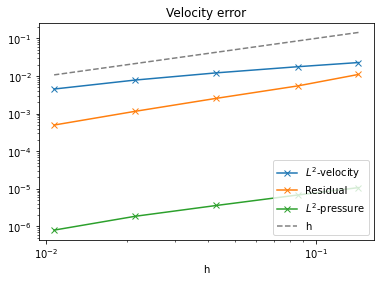

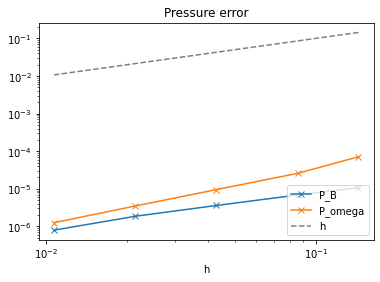

In [30]:
mesh = get_mesh(domain_case)
#SolveProblem(mesh)
errors = Convergence_Study(mesh,n_ref=6-order,perturb_order=perturb_order,estimate_cond=estimate_cond)

# save errror to file
results = []
header_str = ""
problem_str = problem_name(well_posed, domain_case, order,theta)
name_str = "data/{0}.dat".format(problem_str)
for error_type in errors:
            if errors[error_type][0] != None: 
                print(errors[error_type]) 
                results.append(np.array(errors[error_type],dtype=float))
                header_str += "{0} ".format(error_type)
np.savetxt(fname = "{0}/{1}".format(os.path.realpath(''),name_str),
            X = np.transpose(results),
            header = header_str,
            comments = '')

# plotting results using matplotlib
print("...........")
for error_type in errors.keys():
    if error_type != "h" and errors[error_type][0]!= None:
        eoc = [ log(errors[error_type][i-1]/errors[error_type][i])/log(2) for i in range(1,len(errors[error_type]))]
        print("Eoc for {0} = , {1}".format(error_type,eoc))        


#plt.loglog(errors["h"], errors["vel_global_error"], '-x',label="global" ) 
plt.loglog(errors["h"] ,errors["vel_B_error"] , '-x',label="$L^2$-velocity" )
#plt.loglog(errors["h"] ,errors["vel_w_error"] , '-x',label="V_omega" )
plt.loglog(errors["h"] ,errors["jump_res"] , '-x',label="Residual" )
plt.loglog(errors["h"] ,errors["p_B_error"] , '-x',label="$L^2$-pressure"  )
#plt.loglog(errors["h"] ,errors["p_w_error"] , '-x',label="P_omega" )
plt.loglog(errors["h"] ,errors["h"] , color='gray',linestyle='dashed',label="h" )
#plt.loglog(errors["h"] ,errors["h"]**2 , color='gray',linestyle='dotted',label="h^2" )
#plt.loglog(errors["h"] ,errors["h"]**0.75 , '-x',label="slope=0.75" )
plt.legend()
plt.title("Velocity error")
plt.xlabel("h")
plt.legend(loc='lower right')
plt.savefig("velocity-error-{0}.png".format(problem_str),transparent=True)
plt.show()

# plt.loglog(errors["ndof"] ,errors["vel_B_error"] , '-x',label="B" )
# plt.loglog(errors["ndof"] ,errors["vel_w_error"] , '-x',label="omega" )
# plt.loglog(errors["ndof"] ,errors["jump_res"] , '-x',label="Residual" )
# plt.loglog(errors["ndof"] ,errors["h"] , color='gray',linestyle='dashed',label="h" )
# #plt.loglog(errors["h"] ,errors["h"]**2 , color='gray',linestyle='dotted',label="h^2" )
# #plt.loglog(errors["h"] ,errors["h"]**0.75 , '-x',label="slope=0.75" )
# plt.legend()
# plt.title("Velocity error")
# plt.xlabel("ndof")
# plt.savefig("velocity-error-{0}-ndof.png".format(problem_str),transparent=True)
# plt.show()

#plt.loglog(errors["h"], errors["p_global_error"], '-x',label="global" ) 
plt.loglog(errors["h"] ,errors["p_B_error"] , '-x',label="P_B" )
plt.loglog(errors["h"] ,errors["p_w_error"] , '-x',label="P_omega" )
plt.loglog(errors["h"] ,errors["h"] , color='gray',linestyle='dashed',label="h" )
#plt.loglog(errors["h"] ,errors["h"]**2 , color='gray',linestyle='dotted',label="h^2" )
#plt.loglog(errors["h"] ,errors["h"]**0.75 , '-x',label="slope=0.75" )
#plt.legend()

plt.title("Pressure error")
plt.xlabel("h")
plt.legend(loc='lower right')
plt.savefig("pressure-error-{0}.png".format(problem_str),transparent=True)

plt.show()

if estimate_cond == True:
    plt.loglog(errors["h"], errors["cond"], '-x',label="cond" ) 
    plt.loglog(errors["h"] ,errors["cond"][0]*errors["h"]**(-4)/ errors["h"][0]**(-4) , color='gray',linestyle='dashed',label="1/h^4" )
    plt.loglog(errors["h"] ,errors["cond"][0]*errors["h"]**(-3) / errors["h"][0]**(-3) , color='gray',linestyle='dotted',label="1/h^3" )
    #plt.loglog(errors["h"] ,errors["h"]**0.75 , '-x',label="slope=0.75" )
    plt.legend()
    plt.title("Condition number")
    plt.xlabel("h")
    plt.savefig("cond-{0}.png".format(problem_str),transparent=True)
    plt.show()